# Key Indicators of Heart Disease

I found this dataset on Kaggle.  It is the results of a CDC survey looking into the leading causes of heart disease with the aim of detecting and preventing the disease.  According to the CDC, heart disease is the leading cause of death in the United States, so this is a major area of research and study.  A full description as well as the location of the data is found here <https://www.kaggle.com/kamilpytlak/personal-key-indicators-of-heart-disease>.

I downloaded the data to my local PC in order to use offline and did not post to github since it is already easily found on kaggle at the link above.  

Many similar datasets are available online and are even often used and studied for those just learning about machine learning and predictive analystics.  The Pima Indians and Wisconsin Heart Disease datasets come to mind when considering what has already been done in these fields but I feel working with this dataset may improve upon what can be done with those datasets.  What makes this dataset interesting and unique is the sheer size of the survey (approximately 400,000 respondents) as well as the broad spectrum of respondents (not a single ethnic group or region of the country) and the relative recency of the data (2020 as opposed to decades old research).  This helps give a better look at the current US population as a whole.

I will use this dataset to find the key indicators of heart disease by running several supervised machine learning models and finding their most important features.  The models will be a tree based bagging ensemble (Random Forest), a boosting method (AdaBoost), and a support vector machine classifier.

#### Load Data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_csv("heart_2020_cleaned.csv")

In [3]:
data.shape

(319795, 18)

In [4]:
data.columns

Index(['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke',
       'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00


We see the data has over 300,000 observations of 18 different features (17 predictive variables and 1 target).  According to the Kaggle dataset descriptor, no observation is missing any features, though I will of course double check that to confirm.  What is interesting is that, of the 17 predictive variables, only 4 are numeric.  As a result, dummy variables will need to be created for the categorical variables.

In [6]:
data['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [7]:
data['HeartDisease'].value_counts().sum()

319795

The target variable will be Heart Disease (either "No" or "Yes").  The dataset appears to have a severe class imbalance however so this must be accounted for in our analysis.  I will downsample the "No" class (randomly choosing a subset of observations in the class) in order to match the same size as the "Yes" class.

Before doing either of the previously mentioned tasks (creating dummy variables and downsampling), I first want to confirm that the data is indeed clean and free from missing values.  This is done by checking the value counts of each feature and making sure they sum to our total number of observations.

In [8]:
cols = data.columns

numeric_cols = ['BMI','PhysicalHealth','MentalHealth','SleepTime']
categorical_cols = cols.drop(['BMI','PhysicalHealth','MentalHealth','SleepTime'])
categorical_cols

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [9]:
for col in categorical_cols[1:]:
    print(data[col].value_counts())
    print(data[col].value_counts().sum())
    print("\n")
    

No     187887
Yes    131908
Name: Smoking, dtype: int64
319795


No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64
319795


No     307726
Yes     12069
Name: Stroke, dtype: int64
319795


No     275385
Yes     44410
Name: DiffWalking, dtype: int64
319795


Female    167805
Male      151990
Name: Sex, dtype: int64
319795


65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64
319795


White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: Race, dtype: int64
319795


No                         269653
Yes                         40802


We can observe the distributions and correlations of the numeric features as well.  There appear to be no strong correlations present, but the data does indicate there may be a beniefit to normalization of these variables.

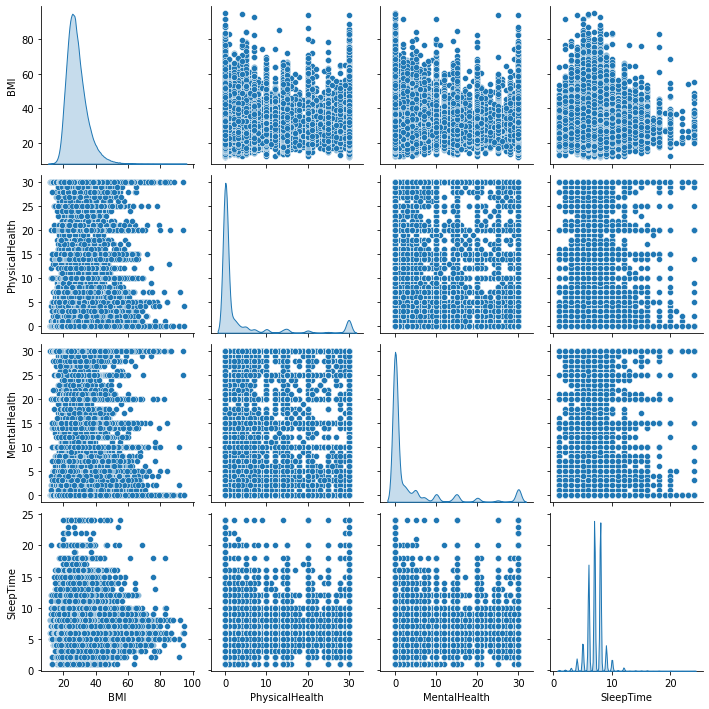

In [10]:
sns.pairplot(data, diag_kind='kde')

So, the data appears to be clean and usable right away.  We do need to create the dummy variables as mentioned so let's do that!

In [11]:
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [12]:
print(data.shape)
data.columns

(319795, 38)


Index(['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime',
       'HeartDisease_Yes', 'Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes',
       'DiffWalking_Yes', 'Sex_Male', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64',
       'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_Asian', 'Race_Black', 'Race_Hispanic',
       'Race_Other', 'Race_White', 'Diabetic_No, borderline diabetes',
       'Diabetic_Yes', 'Diabetic_Yes (during pregnancy)',
       'PhysicalActivity_Yes', 'GenHealth_Fair', 'GenHealth_Good',
       'GenHealth_Poor', 'GenHealth_Very good', 'Asthma_Yes',
       'KidneyDisease_Yes', 'SkinCancer_Yes'],
      dtype='object')

We now have many more columns and we can see that the dummy variables have been created.

Next, we will downsample the negative Heart Disease cases to match the size of the positive cases.

In [13]:
data_Pos = data[data['HeartDisease_Yes']==1].reset_index(drop=True)
data_Neg = data[data['HeartDisease_Yes']==0].reset_index(drop=True)

In [14]:
data_Pos.shape

(27373, 38)

In [15]:
data_Neg.shape

(292422, 38)

In [16]:
np.random.seed(12345)
downsample_idx = np.random.choice(data_Neg.shape[0],size=data_Pos.shape[0])

In [17]:
data_Neg = data_Neg.iloc[downsample_idx,:]

print(data_Pos.shape)
print(data_Neg.shape)

(27373, 38)
(27373, 38)


In [18]:
data_full = pd.concat([data_Pos,data_Neg])
data_full = data_full.sample(frac=1).reset_index(drop=True)
data_full

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,Diabetic_Yes,Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes
0,20.80,30.0,30.0,6.0,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1,25.85,0.0,10.0,8.0,1,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,27.41,0.0,0.0,7.0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
3,28.06,0.0,2.0,6.0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
4,20.09,0.0,0.0,8.0,1,0,0,0,0,0,...,1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54741,35.51,0.0,0.0,8.0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,1,0,0
54742,36.49,0.0,0.0,6.0,0,0,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
54743,25.11,2.0,0.0,8.0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
54744,55.79,20.0,25.0,13.0,1,1,1,0,1,1,...,1,0,0,0,0,1,0,1,0,0


The target feature of the dataset is now balanced and the categorical features have been converted into dummy variables.  The last preprocessing step that needs to be done is normalization of the numeric columns.  I will first split the data into training and test sets and then normalize using the training set data.  By fitting the normalization on only the training data I make sure to avoid any influence from possible outliers in the test set.

In [19]:
from sklearn.model_selection import train_test_split

data_train,data_test = train_test_split(data_full, test_size=0.2, random_state=12345)

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train[numeric_cols])
data_train[numeric_cols] = scaler.transform(data_train[numeric_cols])
data_test[numeric_cols] = scaler.transform(data_test[numeric_cols])

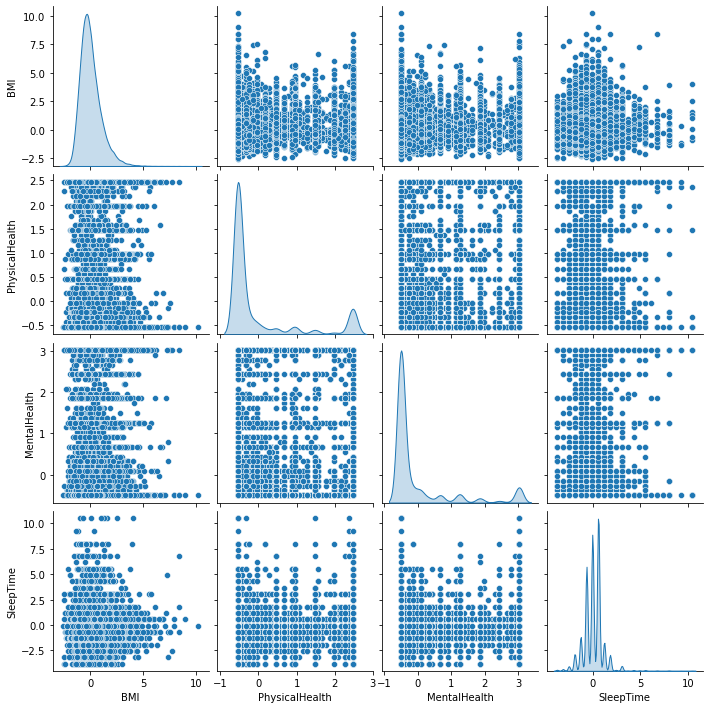

In [21]:
sns.pairplot(data_train[numeric_cols], diag_kind='kde')

We see the distributions of the data havent really changed much so this step is arguably unnecessary, but it will not negatively influence the analysis either way so I will keep it and proceed. 

In [21]:
y_train = data_train[['HeartDisease_Yes']]
X_train = data_train.drop(['HeartDisease_Yes'],axis=1)

## Analysis

#### Model Building and Training

I will look to do this analysis using three different model types we learned in the course.  A tree based bagging ensemble model (Random Forest), a boosting ensemble model (AdaBoost), and a support vector classifier.

#### Random Forest Model

The first ensemble method will be the Random Forest Classifier.  I will run a grid search over a handful of hyperparameters in order to try to find the optimal set of parameters for the classification model.

In [23]:
#this cell runs very slowly, I have saved down the best model and parameters seperately so this cell can be skipped
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RF_clf = RandomForestClassifier(random_state=12345)

param_grid = { 
    'n_estimators': range(30,210,10),
    'max_features': [None, 'sqrt', 'log2'],
    'max_depth' : [None,2,4,6,8,10]
}

CV_RF_clf = GridSearchCV(estimator=RF_clf, param_grid=param_grid, cv= 5,verbose=1)
CV_RF_clf.fit(X_train,y_train.values.ravel())



Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'n_estimators': range(30, 210, 10)},
             verbose=1)

We can view the best parameters from the grid search and copy/save the best model.

In [24]:
CV_RF_clf.best_params_

{'max_depth': 10, 'max_features': None, 'n_estimators': 110}

So, we see the optimal hyperparameters over their respective ranges are a 'max_depth' of 10, 'max_features' equal to None, and number of trees ('n_estimators') as 110.  This is stored as the best estimator of the grid search.  I will save this into a separate model with a shorter name just for ease of use.

In [23]:
#Best_RF_clf = CV_RF_clf.best_estimator_
from sklearn.ensemble import RandomForestClassifier
Best_RF_clf = RandomForestClassifier(random_state=12345,max_depth=10,max_features=None,n_estimators=110)
Best_RF_clf.fit(X_train,y_train.values.ravel())

RandomForestClassifier(max_depth=10, max_features=None, n_estimators=110,
                       random_state=12345)

We can then use the model to predict the classifications on the test set and view various metrics as well as the confusion matrix.

In [22]:
y_test = data_test[['HeartDisease_Yes']]
X_test = data_test.drop(['HeartDisease_Yes'],axis=1)

In [25]:
y_hat = Best_RF_clf.predict(X_test)

Precision Score: 73.6238%
Recall Score: 80.1557%
Accuracy Score: 75.5068%


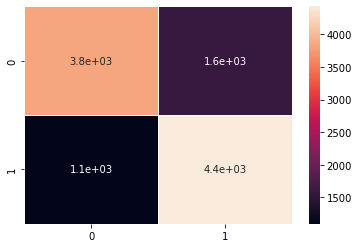

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix


cm = confusion_matrix(y_test,y_hat)
sns.heatmap(cm, linewidths=1, annot=True)

prec = precision_score(y_test,y_hat)
rec = recall_score(y_test,y_hat)
acc = accuracy_score(y_test,y_hat)

print("Precision Score: "+"{:.4%}".format(prec))
print("Recall Score: "+"{:.4%}".format(rec))
print("Accuracy Score: "+"{:.4%}".format(acc))


We see in the above confusion matrix as well as the scores that the model does a reasonably good job of classifying the survey respondents.  With a recall above 80%, this model does a good job of finding those with heart disease.  Let's see if we can improve on this model with a boosting model and/or with a support vector classifier.

#### AdaBoost Model

Next I will perform the same analysis using the AdaBoost classifier.  This will test to see if boosting results in better predictions than the bagging methodology.

In [32]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

AB_clf = AdaBoostClassifier(random_state=12345)

param_grid = { 
    'n_estimators': range(30,210,10),
    'learning_rate': np.linspace(0.01,2.01,25),
}

CV_AB_clf = GridSearchCV(estimator=AB_clf, param_grid=param_grid, cv= 5,verbose=1)
CV_AB_clf.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=12345),
             param_grid={'learning_rate': array([0.01      , 0.09333333, 0.17666667, 0.26      , 0.34333333,
       0.42666667, 0.51      , 0.59333333, 0.67666667, 0.76      ,
       0.84333333, 0.92666667, 1.01      , 1.09333333, 1.17666667,
       1.26      , 1.34333333, 1.42666667, 1.51      , 1.59333333,
       1.67666667, 1.76      , 1.84333333, 1.92666667, 2.01      ]),
                         'n_estimators': range(30, 210, 10)},
             verbose=1)

Again, we can view the best parameters from the grid search and copy/save the best model.

In [33]:
CV_AB_clf.best_params_

{'learning_rate': 1.4266666666666665, 'n_estimators': 60}

In [27]:
#Best_AB_clf = CV_AB_clf.best_estimator_

from sklearn.ensemble import AdaBoostClassifier
Best_AB_clf = AdaBoostClassifier(random_state=12345,learning_rate=1.4266666666666665, n_estimators=60)
Best_AB_clf.fit(X_train,y_train.values.ravel())

AdaBoostClassifier(learning_rate=1.4266666666666665, n_estimators=60,
                   random_state=12345)

We can then use the model to predict the classifications on the test set and view various metrics as well as the confusion matrix.

Precision Score: 75.8344%
Recall Score: 76.9328%
Accuracy Score: 76.0000%


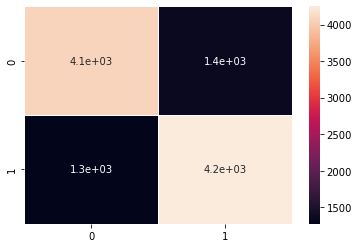

In [28]:
y_hat = Best_AB_clf.predict(X_test)


cm = confusion_matrix(y_test,y_hat)
sns.heatmap(cm, linewidths=1, annot=True)

prec = precision_score(y_test,y_hat)
rec = recall_score(y_test,y_hat)
acc = accuracy_score(y_test,y_hat)

print("Precision Score: "+"{:.4%}".format(prec))
print("Recall Score: "+"{:.4%}".format(rec))
print("Accuracy Score: "+"{:.4%}".format(acc))

This model performs reasonably well, improving on the precision and accuracy of the random forest model but does result in a worse recall score.  This is somewhat disappointing, but not entirely too surprising since both methods have decision tree classifiers as their base estimators.  It does bring up another question of just how similar are these two models.  I will want to look at the most important features for all 3 models at the end in order to answer these questions.  

#### Support Vector Classifier

Lastly, I want to look at modeling the data using a support vector classifier

In [37]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

SVC_clf = SVC(random_state=12345, kernel='rbf')

param_grid = { 
    'C': np.logspace(-3,3,num=7,base=2),
    'gamma': np.logspace(-3,3,num=7,base=2),
}

CV_SVC_clf = GridSearchCV(estimator=SVC_clf, param_grid=param_grid, cv= 5,verbose=1)
CV_SVC_clf.fit(X_train,y_train.values.ravel())

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=SVC(random_state=12345),
             param_grid={'C': array([0.125, 0.25 , 0.5  , 1.   , 2.   , 4.   , 8.   ]),
                         'gamma': array([0.125, 0.25 , 0.5  , 1.   , 2.   , 4.   , 8.   ])},
             verbose=1)

Again, I will look to see what the best parameters are for this model (as well as save the best model into a more descriptive name) and predict the values on the test set to see how well the model can predict the data.

In [38]:
CV_SVC_clf.best_params_

{'C': 2.0, 'gamma': 0.125}

In [23]:
#Best_SVC_clf = CV_SVC_clf.best_estimator_

from sklearn.svm import SVC
Best_SVC_clf = SVC(random_state=12345, kernel='rbf',C=2,gamma=0.125)
Best_SVC_clf.fit(X_train,y_train.values.ravel())

SVC(C=2, gamma=0.125, random_state=12345)

Precision Score: 73.7848%
Recall Score: 81.0791%
Accuracy Score: 75.9269%


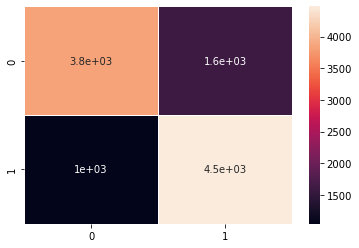

In [30]:
y_hat = Best_SVC_clf.predict(X_test)


cm = confusion_matrix(y_test,y_hat)
sns.heatmap(cm, linewidths=1, annot=True)

prec = precision_score(y_test,y_hat)
rec = recall_score(y_test,y_hat)
acc = accuracy_score(y_test,y_hat)

print("Precision Score: "+"{:.4%}".format(prec))
print("Recall Score: "+"{:.4%}".format(rec))
print("Accuracy Score: "+"{:.4%}".format(acc))

So, we see on the test set the SVC classifier actually has the highest recall score but not the best precision and accuracy.  Also of note was the optimization and fitting of the model were both extremely slow.  

#### Most Important Features

Now that we see the models are reasonably accurate at predicting heart disease, we can use these models to answer the question of what my be the key indicators of heart disease.  To see this, I will look at the most important features of the individual models to see what the most important features for each prediction may be.

<AxesSubplot:title={'center':'Random Forest Feature Importance'}>

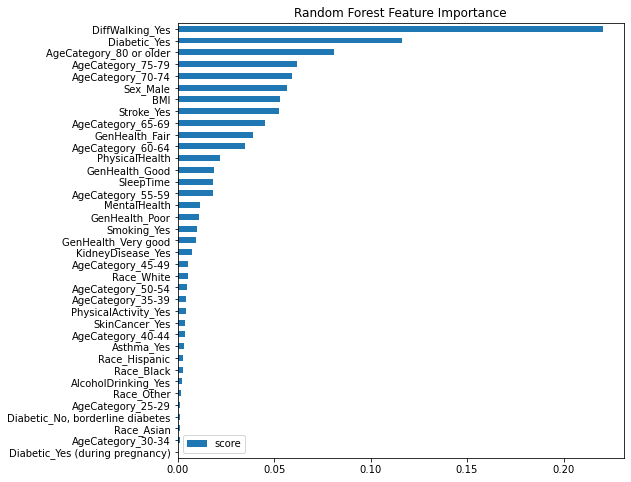

In [35]:
from matplotlib import pyplot as plt

data = pd.DataFrame(data=Best_RF_clf.feature_importances_,index=X_train.columns,columns=['score']).sort_values(by="score",ascending=True)

data.plot(kind='barh',title='Random Forest Feature Importance',figsize=(8,8))

<AxesSubplot:title={'center':'AdaBoost Feature Importance'}>

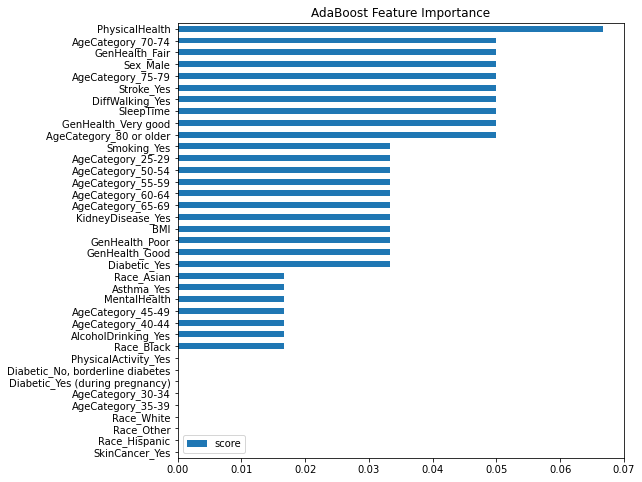

In [36]:
data = pd.DataFrame(data=Best_AB_clf.feature_importances_,index=X_train.columns,columns=['score']).sort_values(by="score",ascending=True)

data.plot(kind='barh',title='AdaBoost Feature Importance',figsize=(8,8))

In [25]:
import shap


np.random.seed(12345)
subset_idx = np.random.choice(X_train.shape[0],size=50)
X_subset = X_train.iloc[subset_idx,:]
explainer = shap.KernelExplainer(Best_SVC_clf.predict,X_subset)

X does not have valid feature names, but SVC was fitted with feature names


In [26]:
shap_values = explainer.shap_values(shap.sample(X_subset,10),n_samples=10)

  0%|          | 0/10 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
The default of 'normalize' will be set to False in version 1.2 and deprec

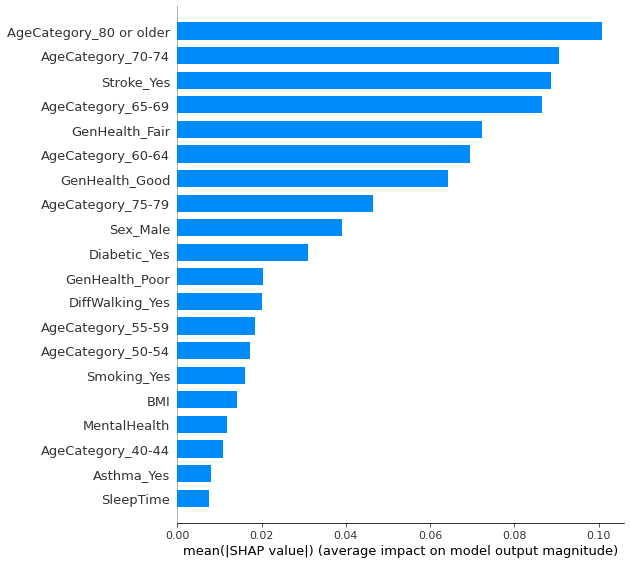

In [39]:
shap.summary_plot(shap_values, feature_names=X_subset.columns, plot_type='bar')

These results are interesting.  We see for each model, there are different factors which are considered important.  For the support vector model, old age seems the most important (note for this model I had to limit the SHAP values to explaining at only a handful of points in order to finish in a reasonable amount of time.)  Stroke is the second most important factor, but that is also likely to be highly correlated with old age.  Physical health doesnt even show up in the most important factors for the SVC, but it is the most important feature for the AdaBoost model.  Smoking seems to show up fairly highly in all models, confirming that it is indeed bad for your health.  BMI (Body Mass Index) shows up as well, but it is not as high of a factor as I was suspecting.  This is interesting and probably shows that the BMI measurement on its own doesnt necessarily tell us too much about the health of a person.

#### Conclusions and Further Analysis

The boosting model (AdaBoost) used appears to have the best combination of predictive power as well as explainability.  The Support Vector Classifier, while having a better recall score, did not have better scores in precision and accuracy and it was significantly slower to compute.  This computational limitation also made it vastly more difficult to find the key indicators as I was forced to limit the sample size to something fairly small in order to finish this project before the course deadline.

Going forward, it may be interesting to compare XGBoost to AdaBoost and see if there is any improvement in the models predictive powers.  Also, because we downsampled by selecting a random subset of the "HeartDisease_No" cases, this entire process can, and probably should, be run again with a different subset in order to confirm the results.